In [3]:
import pandas as pd

ib = pd.read_csv("./ibtracs_genesis.csv", nrows=5)
print(ib.columns.tolist())


['SID', 'genesis_time', 'genesis_lat', 'genesis_lon']


In [13]:
# tc_pipeline.py
# End-to-end ERA5 -> features -> labels -> ML samples (safe, monthly files)
# Compatible with files like:
#   ./data/era_2015_06_u_component_of_wind-v_component_of_wind_850.nc
#   ./data/era_2015_06_temperature-relative_humidity_600.nc
#   ./data/era_2015_06_vorticity_850.nc
# And IBTrACS genesis CSV with columns:
#   SID, genesis_time, genesis_lat, genesis_lon

import os, re, glob, warnings, gc
import numpy as np
import pandas as pd
import xarray as xr

# =========================
# Config (edit as needed)
# =========================
DATA_DIR        = "./data"                # where era_YYYY_MM_*.nc live
FEATURE_DIR     = "./features_safe"       # monthly feature .nc
SAMPLES_DIR     = "./ml_samples"          # monthly flattened CSV/Parquet
IBTRACS_CSV     = "./ibtracs_genesis.csv" # your file

MONTHS_TO_RUN   = [6, 7, 8, 9, 10]        # Jun–Oct (match your downloader)
CHUNKS          = {'time': 1, 'latitude': 200, 'longitude': 200}  # safe for RAM

# Labeling hyperparams
TIME_TOL_H      = 3       # +/- hours window around genesis time
RADIUS_KM       = 250.0   # spatial radius to mark positives
NEG_POS_RATIO   = 5       # cap negatives at 5x positives per month
RANDOM_STATE    = 42

# Output format for samples
WRITE_PARQUET   = False    # set True for Parquet (smaller/faster), False for CSV

os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)

# =========================
# Utilities
# =========================
def _open_nc(path):
    return xr.open_dataset(path, chunks=CHUNKS, cache=False)

def _infer_level_from_name(path):
    m = re.search(r'_(\d{3})\.nc$', os.path.basename(path))
    return int(m.group(1)) if m else None

def _normalize_vars(ds):
    # map CDS long names -> short
    rename_map = {
        'u_component_of_wind': 'u',
        'v_component_of_wind': 'v',
        'temperature': 't',
        'relative_humidity': 'r',
        'vorticity': 'vo',
    }
    to_rename = {k: v for k, v in rename_map.items() if k in ds.data_vars}
    if to_rename:
        ds = ds.rename(to_rename)
    return ds

def _ensure_level_dim(ds, lvl_from_name):
    # unify level coord
    if 'level' in ds.coords:
        return ds
    for cand in ['pressure_level', 'isobaricInhPa']:
        if cand in ds.coords:
            return ds.rename({cand: 'level'})
    # single-level file: inject level
    if lvl_from_name is not None:
        return ds.expand_dims({'level': [lvl_from_name]})
    warnings.warn("Could not infer 'level'; keeping file as-is (may be skipped).")
    return ds

def _normalize_coords(ds):
    # standardize time/level coord names for downstream simplicity
    rename = {}
    for c in ds.coords:
        cl = c.lower()
        if 'time' in cl and c != 'time':
            rename[c] = 'time'
        if c in ('pressure_level', 'isobaricInhPa'):
            rename[c] = 'level'
    if rename:
        ds = ds.rename(rename)
    return ds

def _pick_one_var(ds, varname, level):
    # returns DataArray var(time, lat, lon) at chosen level (or None)
    if varname not in ds:
        return None
    da = ds[varname]
    if 'level' in da.dims:
        if level in da['level']:
            da = da.sel(level=level)
        else:
            return None
    return da

def shear_mag(u200, v200, u850, v850):
    du = u200 - u850
    dv = v200 - v850
    return np.sqrt(du**2 + dv**2)

def _find_file(year, month, key):
    # keys you can request:
    # 'u_component_of_wind-v_component_of_wind_200'
    # 'u_component_of_wind-v_component_of_wind_850'
    # 'temperature-relative_humidity_600'
    # 'temperature-relative_humidity_850'
    # 'temperature-relative_humidity_200'
    # 'vorticity_850'
    patt = os.path.join(DATA_DIR, f"era_{year}_{month:02d}_{key}.nc")
    matches = glob.glob(patt)
    return matches[0] if matches else None

# =========================
# Phase 1: Features (safe)
# =========================
def compute_features_for_month_safe(year, month):
    f_uv200 = _find_file(year, month, "u_component_of_wind-v_component_of_wind_200")
    f_uv850 = _find_file(year, month, "u_component_of_wind-v_component_of_wind_850")
    f_tr600 = _find_file(year, month, "temperature-relative_humidity_600")
    f_t850  = _find_file(year, month, "temperature-relative_humidity_850")
    f_t200  = _find_file(year, month, "temperature-relative_humidity_200")
    f_vo850 = _find_file(year, month, "vorticity_850")

    if not any([f_uv200, f_uv850, f_tr600, f_t850, f_t200, f_vo850]):
        print(f"[{year}-{month:02d}] no files found. Skipping.")
        return

    # --- vo at 850
    vo850 = None
    if f_vo850:
        ds = _open_nc(f_vo850)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_vo850)))
        vo850 = _pick_one_var(ds, 'vo', 850)
        ds.close(); del ds; gc.collect()

    # --- u,v at 200
    u200 = v200 = None
    if f_uv200:
        ds = _open_nc(f_uv200)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_uv200)))
        u200 = _pick_one_var(ds, 'u', 200)
        v200 = _pick_one_var(ds, 'v', 200)
        ds.close(); del ds; gc.collect()

    # --- u,v at 850
    u850 = v850 = None
    if f_uv850:
        ds = _open_nc(f_uv850)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_uv850)))
        u850 = _pick_one_var(ds, 'u', 850)
        v850 = _pick_one_var(ds, 'v', 850)
        ds.close(); del ds; gc.collect()

    # --- r,t at 600
    rh600 = t600 = None
    if f_tr600:
        ds = _open_nc(f_tr600)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_tr600)))
        rh600 = _pick_one_var(ds, 'r', 600)
        t600  = _pick_one_var(ds, 't', 600)
        ds.close(); del ds; gc.collect()

    # --- t at 850
    t850 = None
    if f_t850:
        ds = _open_nc(f_t850)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_t850)))
        t850 = _pick_one_var(ds, 't', 850)
        ds.close(); del ds; gc.collect()

    # --- t at 200
    t200 = None
    if f_t200:
        ds = _open_nc(f_t200)
        ds = _normalize_vars(_ensure_level_dim(ds, _infer_level_from_name(f_t200)))
        t200 = _pick_one_var(ds, 't', 200)
        ds.close(); del ds; gc.collect()

    # assemble feature dataset
    feat = xr.Dataset()

    # copy coords from the first available DA
    for candidate in [vo850, u200, v200, u850, v850, rh600, t600, t850, t200]:
        if candidate is not None:
            for c in ['time','valid_time','datetime','latitude','longitude']:
                if c in candidate.coords and c not in feat.coords:
                    feat = feat.assign_coords({c: candidate[c]})
            break

    if vo850 is not None:
        feat['vo850'] = vo850

    if all(da is not None for da in [u200, v200, u850, v850]):
        ws = shear_mag(u200, v200, u850, v850)
        ws.name = 'wshear_200_850'
        ws.attrs.update(units='m s^-1', long_name='Vertical wind shear magnitude (200–850 hPa)')
        feat['wshear_200_850'] = ws

    if rh600 is not None:
        feat['rh600'] = rh600
        feat['rh600'].attrs.update(units='%', long_name='Relative humidity at 600 hPa')

    if (t600 is not None) and (t850 is not None):
        d1 = (t600 - t850).rename('t600_minus_t850')
        d1.attrs.update(units='K', long_name='T600 - T850')
        feat['t600_minus_t850'] = d1

    if (t200 is not None) and (t850 is not None):
        d2 = (t200 - t850).rename('t200_minus_t850')
        d2.attrs.update(units='K', long_name='T200 - T850')
        feat['t200_minus_t850'] = d2

    # normalize coords so every saved file has time/latitude/longitude
    feat = _normalize_coords(feat)

    out_nc = os.path.join(FEATURE_DIR, f"features_{year}_{month:02d}.nc")
    encoding = {v: {'zlib': True, 'complevel': 4, 'dtype': 'float32'} for v in feat.data_vars}
    with xr.set_options(file_cache_maxsize=1):
        feat.to_netcdf(out_nc, encoding=encoding, engine='netcdf4', compute=True)

    del feat; gc.collect()
    print(f"[{year}-{month:02d}] wrote {out_nc}")

def compute_features_for_year(year):
    for m in MONTHS_TO_RUN:
        try:
            compute_features_for_month_safe(year, m)
        except Exception as e:
            warnings.warn(f"Feature fail {year}-{m:02d}: {e}")

# =========================
# Phase 2: Labels + Samples
# =========================
def load_genesis_points(csv_path):
    # Your file columns: ['SID','genesis_time','genesis_lat','genesis_lon']
    df = pd.read_csv(csv_path)
    req = {'SID','genesis_time','genesis_lat','genesis_lon'}
    if not req.issubset(df.columns):
        raise ValueError(f"IBTrACS CSV must have {req}; got {set(df.columns)}")
    df['gen_time'] = pd.to_datetime(df['genesis_time'], utc=True, errors='coerce')
    df = df.dropna(subset=['gen_time', 'genesis_lat', 'genesis_lon'])
    gen = df[['SID','gen_time','genesis_lat','genesis_lon']].rename(
        columns={'genesis_lat':'gen_lat', 'genesis_lon':'gen_lon'}
    )
    return gen

def haversine_km(lat1, lon1, lat2, lon2):
    # dateline-safe
    R = 6371.0
    p1 = np.deg2rad(lat1); p2 = np.deg2rad(lat2)
    dphi = np.deg2rad(lat2 - lat1)
    dlon = (lon2 - lon1 + 180.0) % 360.0 - 180.0
    dl   = np.deg2rad(dlon)
    a = np.sin(dphi/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dl/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def _detect_coord_names(ds):
    # returns (time_name, lat_name, lon_name)
    time_name = next((c for c in ds.coords if 'time' in c.lower()), None)
    if time_name is None:
        raise ValueError(f"No time-like coord in dataset. Coords: {list(ds.coords)}")
    lat_name = next((c for c in ds.coords if 'lat' in c.lower()), None)
    lon_name = next((c for c in ds.coords if 'lon' in c.lower()), None)
    if lat_name is None or lon_name is None:
        raise ValueError(f"No lat/lon coord in dataset. Coords: {list(ds.coords)}")
    return time_name, lat_name, lon_name

def label_month(ds, gen_df):
    # auto-detect coord names
    time_name = next((c for c in ds.coords if 'time' in c.lower()), None)
    if time_name is None:
        raise ValueError(f"No time-like coord in dataset. Coords: {list(ds.coords)}")
    lat_name  = next((c for c in ds.coords if 'lat' in c.lower()), None)
    lon_name  = next((c for c in ds.coords if 'lon' in c.lower()), None)
    if lat_name is None or lon_name is None:
        raise ValueError(f"No lat/lon coord in dataset. Coords: {list(ds.coords)}")

    # ---- times: compare in UTC (tz-aware), store as tz-naive (UTC) in coords
    t_idx = pd.to_datetime(ds[time_name].values)             # likely tz-naive
    if getattr(t_idx, "tz", None) is None:
        t_utc = t_idx.tz_localize("UTC")                    # make UTC-aware
    else:
        t_utc = t_idx.tz_convert("UTC")
    t_naive = t_utc.tz_convert(None)                        # xarray-friendly

    lat = ds[lat_name].values
    lon = ds[lon_name].values
    LAT2D, LON2D = np.meshgrid(lat, lon, indexing='ij')

    labels = np.zeros((len(t_utc), len(lat), len(lon)), dtype=np.uint8)

    for ti, t in enumerate(t_utc):
        sub = gen_df[
            (gen_df['gen_time'] >= t - pd.Timedelta(hours=TIME_TOL_H)) &
            (gen_df['gen_time'] <= t + pd.Timedelta(hours=TIME_TOL_H))
        ]
        if sub.empty:
            continue
        lab2d = np.zeros_like(labels[0])
        for _, row in sub[['gen_lat','gen_lon']].iterrows():
            dkm = haversine_km(LAT2D, LON2D, row['gen_lat'], row['gen_lon'])
            lab2d |= (dkm <= RADIUS_KM)
        labels[ti] = lab2d.astype(np.uint8)

    # coords: tz-naive (UTC) to satisfy xarray
    return xr.DataArray(
        labels,
        coords={time_name: t_naive.values, lat_name: lat, lon_name: lon},
        dims=(time_name, lat_name, lon_name),
        name='genesis_label'
    )


def label_and_write_samples_for_month(path_nc, gen_all):
    base = os.path.basename(path_nc)
    out_base = base.replace(".nc", ".parquet" if WRITE_PARQUET else ".csv")
    out_path = os.path.join(SAMPLES_DIR, out_base)

    ds = xr.open_dataset(path_nc, chunks={'time':1})
    lab = label_month(ds, gen_all)
    ds = ds.assign(genesis_label=lab)

    cols = [c for c in ['vo850','wshear_200_850','rh600','t600_minus_t850','t200_minus_t850'] if c in ds]
    df = ds[cols + ['genesis_label']].to_dataframe().reset_index().dropna()

    # downsample negatives to control class imbalance and file size
    pos = df[df['genesis_label'] == 1]
    neg = df[df['genesis_label'] == 0]
    if len(pos) > 0 and len(neg) > 0:
        keep_neg = min(len(neg), NEG_POS_RATIO * len(pos))
        neg = neg.sample(keep_neg, random_state=RANDOM_STATE)
        df = pd.concat([pos, neg], axis=0).sample(frac=1, random_state=RANDOM_STATE)

    if WRITE_PARQUET:
        df.to_parquet(out_path, index=False)
    else:
        df.to_csv(out_path, index=False)

    print("  wrote", out_path, f"({len(df)} rows)")
    ds.close(); del ds, df; gc.collect()

def label_and_write_samples_for_year(year):
    gen_all = load_genesis_points(IBTRACS_CSV)
    # Optional: restrict to the year for speed
    gen_year = gen_all[(gen_all['gen_time'].dt.year == year)]
    if gen_year.empty:
        print(f"[{year}] No genesis rows for this year; labels will be zeros (skip downsampling).")
        gen_year = gen_all  # or keep empty to yield all zeros

    for m in MONTHS_TO_RUN:
        path = os.path.join(FEATURE_DIR, f"features_{year}_{m:02d}.nc")
        if not os.path.exists(path):
            print(f"[{year}-{m:02d}] feature file missing, skip.")
            continue
        try:
            print(f"→ label+sample {year}-{m:02d}")
            label_and_write_samples_for_month(path, gen_year)
        except Exception as e:
            warnings.warn(f"Label/sample fail {year}-{m:02d}: {e}")

# =========================
# Runners
# =========================
def run_one_year(year):
    """Test on a single year."""
    compute_features_for_year(year)
    label_and_write_samples_for_year(year)

def run_span_features_and_samples(start_year, end_year_inclusive):
    """Multi-year (e.g., 30-year) pipeline."""
    # 1) Features
    for y in range(start_year, end_year_inclusive + 1):
        print(f"=== FEATURES {y} ===")
        compute_features_for_year(y)
    # 2) Labels + Samples
    for y in range(start_year, end_year_inclusive + 1):
        print(f"=== LABELS+SAMPLES {y} ===")
        label_and_write_samples_for_year(y)

# =========================
# Main (examples)
# =========================
if __name__ == "__main__":
    # Example: test one year first
    # run_one_year(2015)

    # Example: 30 years (adjust range as you like)
    # e.g., 1995–2024 inclusive is 30 years
    # run_span_features_and_samples(1995, 2024)
    pass


In [15]:
label_and_write_samples_for_year(2015)


→ label+sample 2015-06
  wrote ./ml_samples/features_2015_06.csv (2330460 rows)
→ label+sample 2015-07
  wrote ./ml_samples/features_2015_07.csv (2472 rows)
→ label+sample 2015-08
  wrote ./ml_samples/features_2015_08.csv (3192 rows)
→ label+sample 2015-09
  wrote ./ml_samples/features_2015_09.csv (4788 rows)
→ label+sample 2015-10
  wrote ./ml_samples/features_2015_10.csv (1590 rows)


In [16]:
import pandas as pd

# path to one of your monthly files
path = "./ml_samples/features_2015_06.csv"

# read only the first few rows (to check structure)
df = pd.read_csv(path, nrows=10)
print(df.head())
print(df.columns)


         time  latitude  longitude     vo850  wshear_200_850      rh600  \
0  2015-06-01      30.0     100.00  0.000023       27.656956  93.586180   
1  2015-06-01      30.0     100.25 -0.000014       27.209576  87.472900   
2  2015-06-01      30.0     100.50 -0.000024       27.195965  86.062744   
3  2015-06-01      30.0     100.75 -0.000012       27.664257  80.933840   
4  2015-06-01      30.0     101.00  0.000018       27.551495  79.914310   

   t600_minus_t850  t200_minus_t850  genesis_label  level  
0       -15.166992       -66.649570              0  850.0  
1       -14.682617       -66.874176              0  850.0  
2       -14.586914       -67.428860              0  850.0  
3       -13.967773       -67.936676              0  850.0  
4       -12.918945       -67.789215              0  850.0  
Index(['time', 'latitude', 'longitude', 'vo850', 'wshear_200_850', 'rh600',
       't600_minus_t850', 't200_minus_t850', 'genesis_label', 'level'],
      dtype='object')


In [17]:
# Read in manageable chunks (each 200k rows)
reader = pd.read_csv(path, chunksize=200_000)
df = pd.concat(reader, ignore_index=True)
print(df.shape)


(2330460, 10)


2015-06  positives=0  negatives=2,330,460


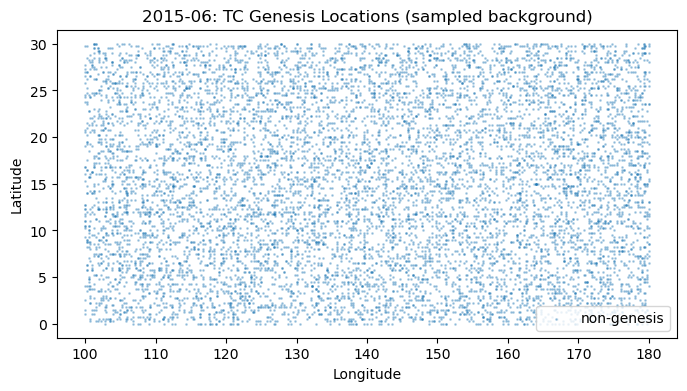

2015-07  positives=412  negatives=2,060


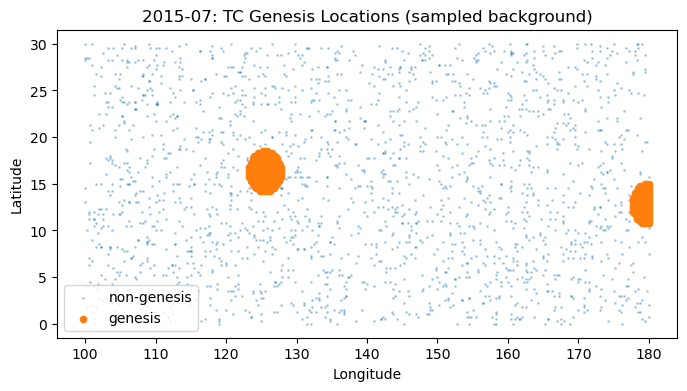

2015-08  positives=532  negatives=2,660


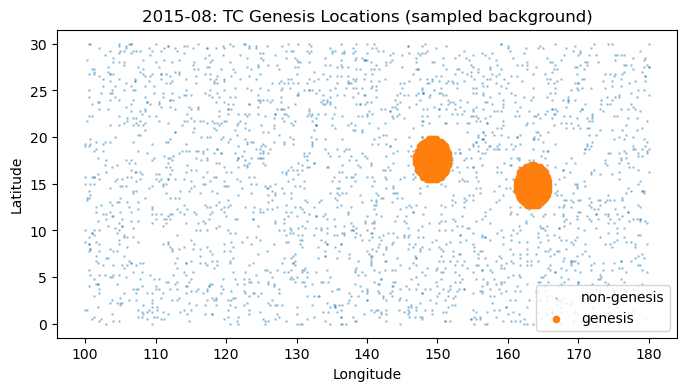

2015-09  positives=798  negatives=3,990


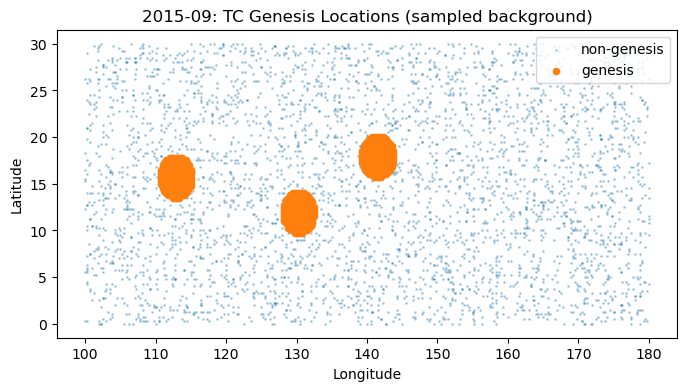

2015-10  positives=265  negatives=1,325


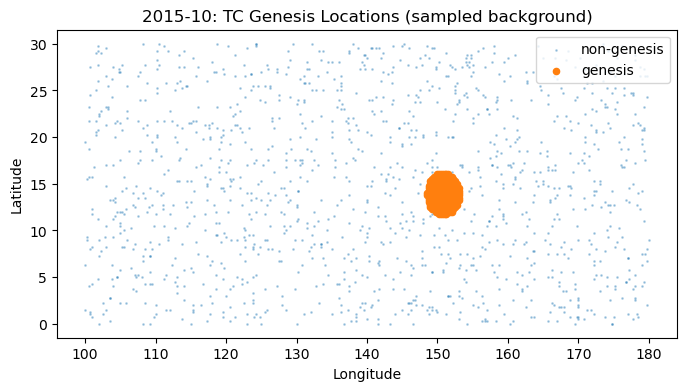

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def quick_plot_month(year, month, base="./ml_samples"):
    path = os.path.join(base, f"features_{year}_{month:02d}.csv")
    if not os.path.exists(path):
        print(f"[skip] {path} not found")
        return

    # Load only needed columns (saves memory)
    cols = ['latitude','longitude','genesis_label']
    df = pd.read_csv(path, usecols=cols)

    # Counts
    cnt = df['genesis_label'].value_counts().to_dict()
    pos_n = cnt.get(1, 0)
    neg_n = cnt.get(0, 0)
    print(f"{year}-{month:02d}  positives={pos_n:,}  negatives={neg_n:,}")

    # Sample a subset of negatives to see the background
    neg_sample = df[df['genesis_label']==0].sample(min(10_000, neg_n), random_state=0)
    pos = df[df['genesis_label']==1]

    plt.figure(figsize=(8,4))
    if not neg_sample.empty:
        plt.scatter(neg_sample['longitude'], neg_sample['latitude'],
                    s=1, alpha=0.3, label='non-genesis')
    if not pos.empty:
        plt.scatter(pos['longitude'], pos['latitude'],
                    s=20, label='genesis')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.title(f'{year}-{month:02d}: TC Genesis Locations (sampled background)')
    plt.legend()
    plt.show()

# Run for July–October 2015
for m in [6,7, 8, 9, 10]:
    quick_plot_month(2015, m)


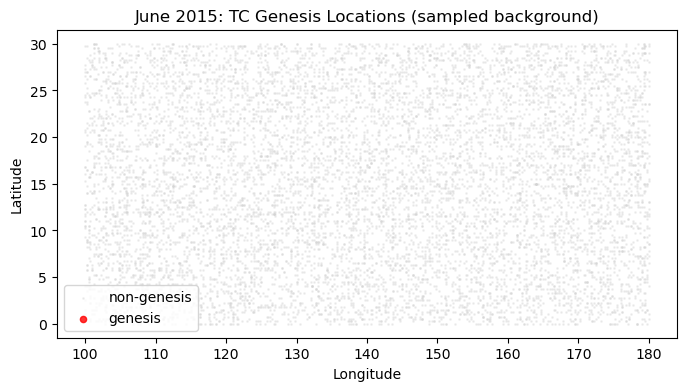

genesis_label
0    2330460
Name: count, dtype: int64